In [41]:
import lhapdf
#import ROOT
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rcParams['text.usetex'] = True

from iminuit import Minuit
import sys
sys.path.insert(1,'DSS')
import fDSS_

In [42]:
with open('yield_ratio_xz_combined_withRungroups.json') as j_RD:
    RDxz = json.load(j_RD)
with open('yield_ratio_Q2xzRunG_combined.json') as j_Q2xzRG:
    RD_Q2xzRG = json.load(j_Q2xzRG)
#colors = ['antiquewhite','antiquewhite4','aqua','aquamarine3','aquamarine4','azure4','banana','bisque4','blue2','blueviolet','brick','brown','burlywood4','cadetblue4','cadmiuorange','chartreuse4','cobalk','cobaltgreen','cornflowerblue','coral4','crimson','darkgoldenrod','darkgreen','darkorange2','darksamon','darkorchid2','darkseagreen4','darkslategrey3','flesh','goldenrod1','green4','hotpink','indianred3','lemonchiffon4','lightblue4','lightgoldenrod4','lightsalmon3','lightsteelblue','manganeseblue','mediumorchid3','mediumturquoise','navy','olive','orange','orangered1','palevioletred','pink3','red2','royalblue2','seagreen3','sienna2','slateblue2','springgreen3','tan2','teal','thistle','tomato1','violetred2','wheat','yellow3']
colors = ['antiquewhite','antiquewhite','aqua','aquamarine','azure','banana','bisque','blue','blueviolet','brown','burlywood','cadetblue','chartreuse','cornflowerblue','coral','crimson','darkgoldenrod','darkgreen','darkorange','darksalmon','darkorchid','darkseagreen','darkslateblue','darkslategrey','darkviolet','dimgray','firebrick','forestgreen','goldenrod','green','greenyellow','hotpink','indigo','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow']
def Get_weighted(values,errs):
    sums = 0
    sig = 0
    for i in range(len(values)):
        for j in range(len(errs)):
            sums+=values[i]/(errs[i]*errs[i])
            sig+=1/(errs[i]*errs[i])
    return sums/sig   
def Get_weighted_average(value,error):
    sum_mean = 0
    sum_sigma = 0
    for i in range(len(value)):
        sum_mean += value[i]/(error[i]*error[i])
        sum_sigma += 1/(error[i]*error[i])
    return sum_mean/sum_sigma
def Get_weighted_sigma(value,error):
    sum_sigma = 0
    for i in range(len(value)):
        sum_sigma += 1/(error[i]*error[i])
    return math.sqrt(1/sum_sigma)



In [43]:
## Getting a PDF member object

p_cteq6 = lhapdf.mkPDF("cteq6l1", 0)
p_cteq6 = lhapdf.mkPDF("cteq6l1/0")
def Ax(Q,xbj):
    return -4/(3*(p_cteq6.xfxQ(2,xbj,Q)+p_cteq6.xfxQ(1,xbj,Q)))
def Bx(Q,xbj):
    return  2.5+5*(p_cteq6.xfxQ(-2,xbj,Q)+p_cteq6.xfxQ(-1,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    
def Get_D_fav(Q,z_had):
    """
    #Kretzer
    Dd_plus = 0.217*z_had**-1.805*(1-z_had)**2.037
    D_fav = Dd_plus;
    """
    #Binneweis
    Lambda = 0.227
    sv = math.log(math.log(Q*Q/(Lambda**2))/math.log(2/Lambda**2))
    N = 1.150-1.522*sv+1.378*sv**2-0.527*sv**3
    a1 = -0.740-1.680*sv+1.546*sv**2-0.596*sv**3
    a2 = 1.430+0.543*sv-0.023*sv**2
    D_sum = N*z_had**a1*(1.0-z_had)**a2
    #Ratio of D-/D+ from P.Geiger's thesis HERMES
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    D_fav = D_sum/(1.0+R_D)
    
    return D_fav
def Get_D_unfav(Q,z_had):
    """
    #Kretzer
    Du_plus = 0.689*z_had**-1.039*(1-z_had)**1.241
    D_unfav = Du_plus;
    """
    #Binneweis
    Lambda = 0.227
    sv = math.log(math.log(Q*Q/(Lambda**2))/math.log(2/Lambda**2))
    N = 1.150-1.522*sv+1.378*sv**2-0.527*sv**3
    a1 = -0.740-1.680*sv+1.546*sv**2-0.596*sv**3
    a2 = 1.430+0.543*sv-0.023*sv**2
    D_sum = N*z_had**a1*(1.0-z_had)**a2
    #Ratio of D-/D+ from P.Geiger's thesis HERMES
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    D_unfav = D_sum/(1.0+1.0/R_D)
    
    return D_unfav
def Dz(Q,z_had):
    '''
    #Kretzer
    Dd_plus = 0.217*z_had**-1.805*(1-z_had)**2.037
    Du_plus = 0.689*z_had**-1.039*(1-z_had)**1.241 
    delta_z = Dd_plus/Du_plus
    
    #P.Geiger's thesis
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    delta_z = R_D
    '''
    #fDSS
    duplus = fDSS_.fdss(1,1,0,z_hadron,Q*Q)[0]
    duminus = fDSS_.fdss(1,-1,0,z_hadron,Q*Q)[0]
    delta_z = duminus/duplus
    return (1-delta_z)/(1+delta_z)

def CSVx(Q,z_had,xbj,RDmeas):
    return (Bx(Q,xbj)-Dz(Q,z_had)*(RDmeas+2.5))/Ax(Q,xbj)
def CSVx_err(Q,z_had,xbj,RDmeas):
    return Dz(Q,z_had)*(RDmeas)/Ax(Q,xbj)

LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042


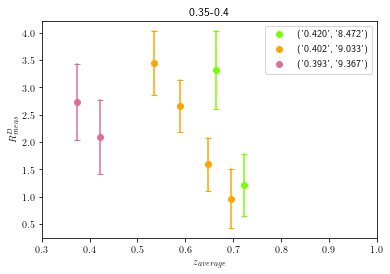

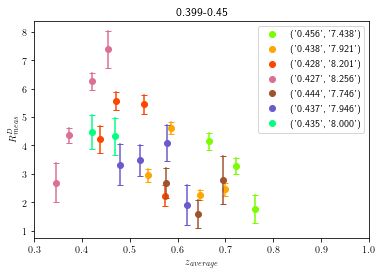

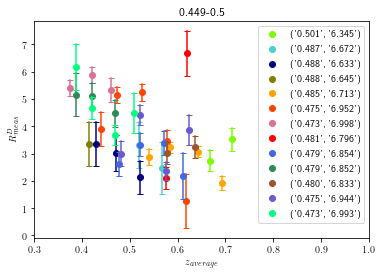

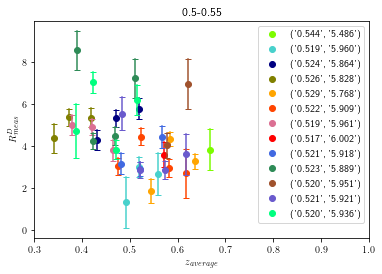

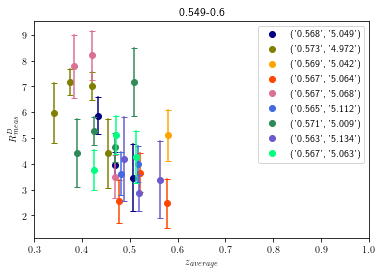

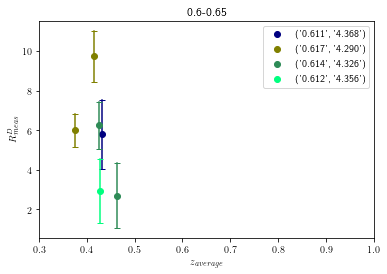

In [44]:
Q2 = 5.5
#RDs_xbj = []
#RDs_xbj_err = []
for key_xbj,xbj_value in RDxz["5.500000"].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RDi=float(z_value["value"])
            RDi_error = float(z_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(z_value["z_corr"])*z_hadron
            zs.append(zi_corr)
            xbji_corr = float(z_value["xbj_corr"])*xbj
            xbji_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbji_corr)
            xbj_corr_errs.append(xbji_corr_err)
            ax.plot([zi_corr,zi_corr],[RDi+RDi_error,RDi-RDi_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = (xbj_corr_str[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        #RD_xbj = Get_weighted_average(RDs,RDs_error)
        #RD_xbj_err = Get_weighted_sigma(RDs,RDs_error)
        #RDs_xbj.append(RD_xbj)
        #RDs_xbj_err.append(RD_xbj_err)
        

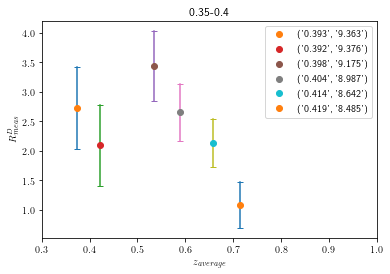

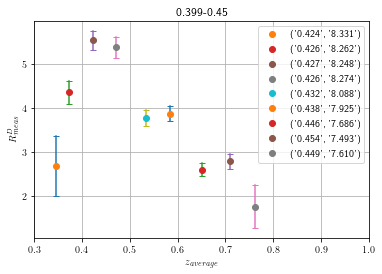

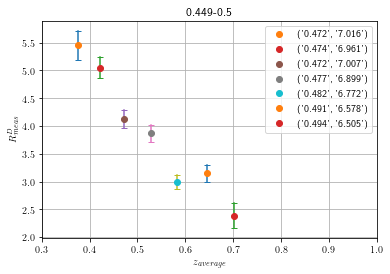

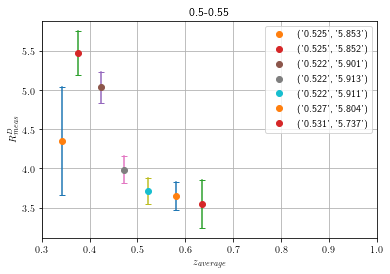

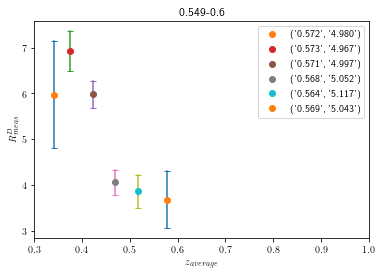

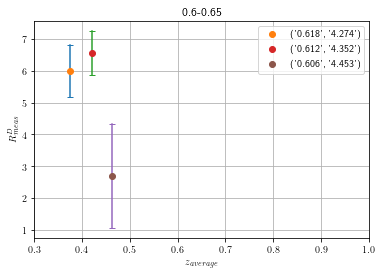

In [45]:

Q2 = 5.5
#RDs_xbj = []
#RDs_xbj_err = []
CSVs = []
CSVs_err = []
xbj_all_corr=[]
#ones Q2 = 5.5, twos Q2 = 4.75, threes Q2 = 4,
xbj_ones_corr = []
CSV_ones = []
CSV_ones_err = []
xbj_twos_corr = []
CSV_twos = []
CSV_twos_err = []
xbj_threes_corr = []
CSV_threes = []
CSV_threes_err = []
for key_xbj,xbj_value in RD_Q2xzRG["5.500000"].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_one_corr = []
    xbj_one_err_corr = []
    CSV_one = []
    CSV_one_err = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            #print('RD_error ',RD_error)
            zi_corr = float(RunGroup_value["z_corr"])*z_hadron
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])*z_hadron
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])*xbj
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        #print('RDs ',RDs)
        #print('RDs err ',RDs_error)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        #print('RD',RD)
        #print('RD_err',RD_err)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = (str(xbj_corr)[0:5],str(W2)[0:5]))
        xbj_all_corr.append(xbj_corr)
        CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
        CSVxi_err = xbj_corr*CSVx_err(math.sqrt(Q2),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_one_corr.append(xbj_corr)
        xbj_onei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_one_err_corr.append(xbj_onei_err_corr)
        CSV_one.append(CSVxi)
        CSV_one_err.append(CSVxi_err)
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        plt.grid()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
    xbj_one = Get_weighted_average(xbj_one_corr,xbj_one_err_corr)
    xbj_ones_corr.append(xbj_one)
    #print('CSVs',CSV_one)
    #print('CSCVs err',CSV_one_err)
    CSVxi_one = Get_weighted_average(CSV_one,CSV_one_err)
    CSVxi_one_err = Get_weighted_sigma(CSV_one,CSV_one_err)
    #print('CSV one', CSVxi_one)
    #print('CSV one err',CSVxi_one_err)
    CSV_ones.append(CSVxi_one)
    CSV_ones_err.append(CSVxi_one_err)

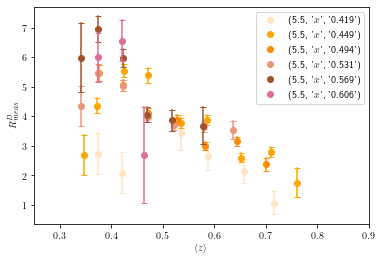

In [51]:
Q2 = 5.5
i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG["5.500000"].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])*z_hadron
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])*z_hadron
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])*xbj
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    plt.plot(z_corrs,RD_alls,"o",label = (Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    i_color +=1

(-0.1, 0.15)

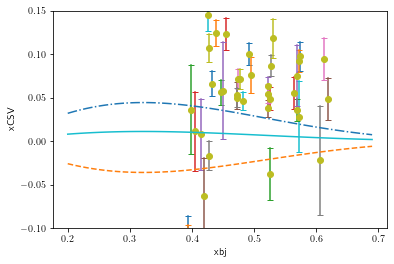

In [52]:
#print(CSVs)
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")    
plt.plot(xbj_all_corr,CSVs,"o")
        #CSVs_err
    
def delta_udv(parameter):
    x = np.arange(0.2,0.7,0.01)
    return x*parameter*(1-x)**4*x**-0.5*(x-0.0909)
x_axis = np.arange(0.2,0.7,0.01)
y_delta_uv = delta_udv(-0.2)
y_delta_dv = delta_udv(0.2)
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
y_delta_uv_up = delta_udv(0.8)
y_delta_uv_low = delta_udv(-0.8)
y_delta_dv_up = delta_udv(-0.65)
y_delta_dv_low = delta_udv(0.65)
#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel('xbj')
plt.ylabel('xCSV')
plt.ylim(-0.1,0.15)

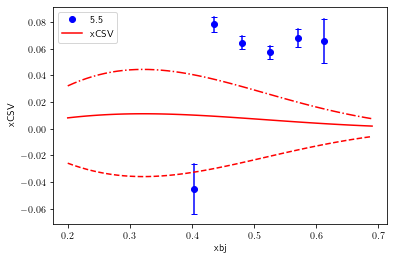

In [53]:
ax = fig.add_subplot()
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "b")
plt.plot(xbj_ones_corr,CSV_ones,"bo",label = Q2)
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
plt.legend()

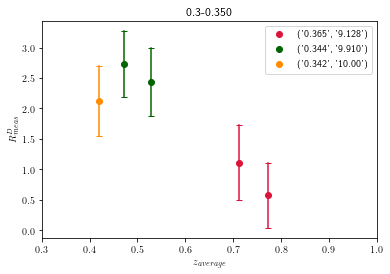

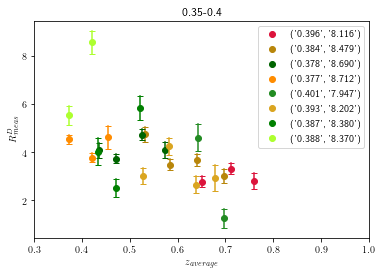

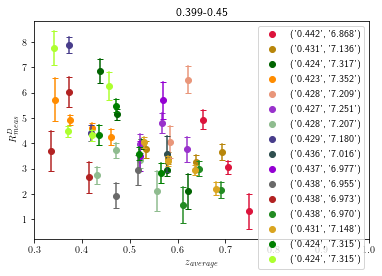

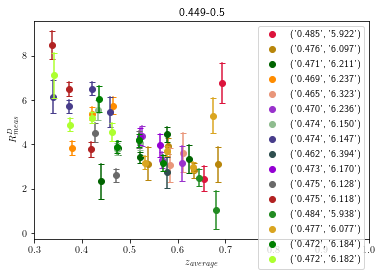

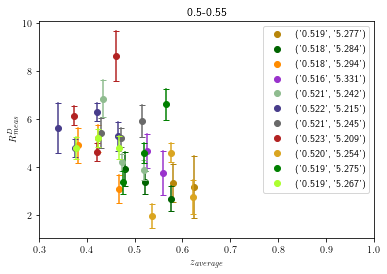

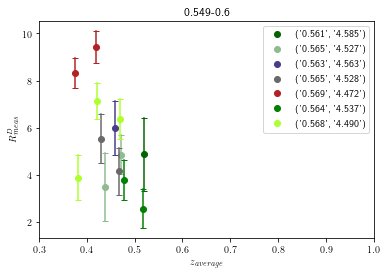

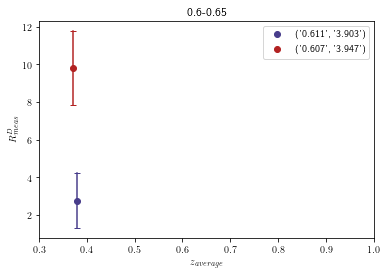

In [54]:
Q2 = 4.75
for key_xbj,xbj_value in RDxz["4.750000"].items():
   
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RDi=float(z_value["value"])
            RDi_error = float(z_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(z_value["z_corr"])*z_hadron
            zs.append(zi_corr)
            xbji_corr = float(z_value["xbj_corr"])*xbj
            xbji_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbji_corr)
            xbj_corr_errs.append(xbji_corr_err)
            ax.plot([zi_corr,zi_corr],[RDi+RDi_error,RDi-RDi_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = (xbj_corr_str[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])


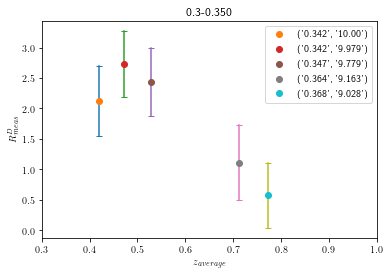

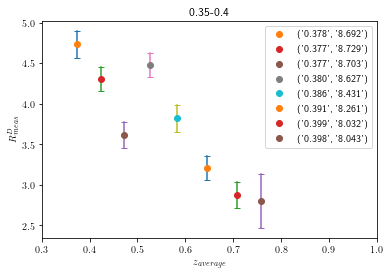

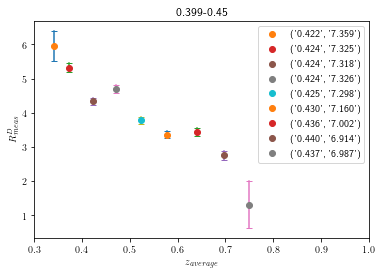

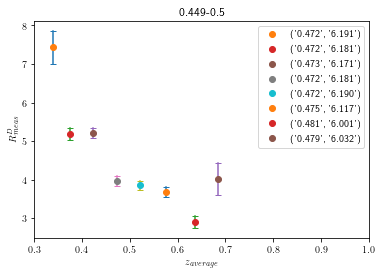

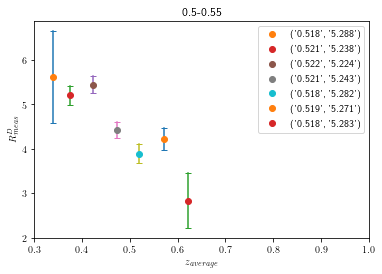

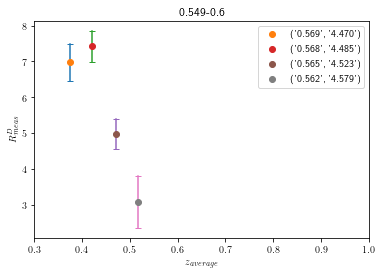

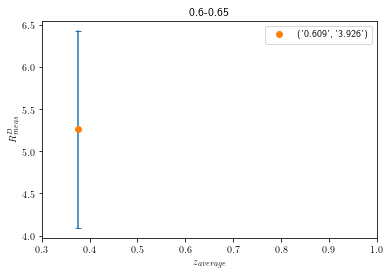

In [55]:
CSVs = []
CSVs_err = []
xbj_all_corr=[]
for key_xbj,xbj_value in RD_Q2xzRG["4.750000"].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        xbj_two_corr = []
        xbj_two_err_corr = []
        CSV_two = []
        CSV_two_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])*z_hadron
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])*z_hadron
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])*xbj
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_all_corr.append(xbj_corr)
        CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
        CSVxi_err = xbj_corr*CSVx_err(math.sqrt(Q2),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_two_corr.append(xbj_corr)
        xbj_twoi_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_two_err_corr.append(xbj_twoi_err_corr)
        CSV_two.append(CSVxi)
        CSV_two_err.append(CSVxi_err)
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = (str(xbj_corr)[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
    xbj_two = Get_weighted_average(xbj_two_corr,xbj_two_err_corr)
    xbj_twos_corr.append(xbj_two)
    CSVxi_two = Get_weighted_average(CSV_two,CSV_two_err)
    CSVxi_two_err = Get_weighted_sigma(CSV_two,CSV_two_err)
    CSV_twos.append(CSVxi_two)
    CSV_twos_err.append(CSVxi_two_err)

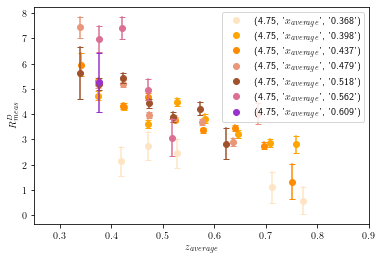

In [57]:
Q2 = 4.75
i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG["4.750000"].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])*z_hadron
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])*z_hadron
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])*xbj
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    plt.plot(z_corrs,RD_alls,"o",label = (Q2,r'$x_{average}$',str(xbj_corr)[0:5]),color = colors_all[i_color])
    plt.xlabel(r'$z_{average}$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    i_color +=1

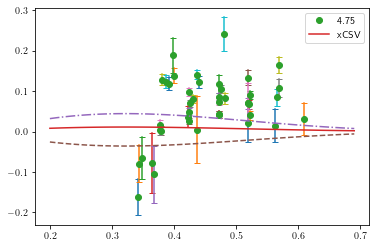

In [24]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")
plt.plot(xbj_all_corr,CSVs,"o",label = Q2)
        #CSVs_err
    


plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')

#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.legend()

Text(0, 0.5, 'xCSV')

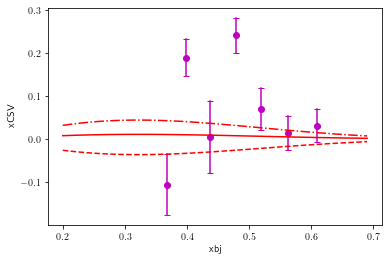

In [25]:
ax = fig.add_subplot()
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo")
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')

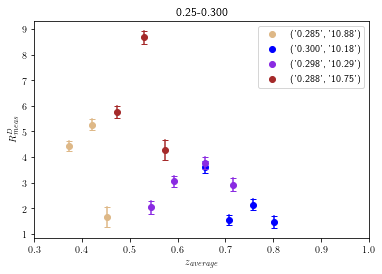

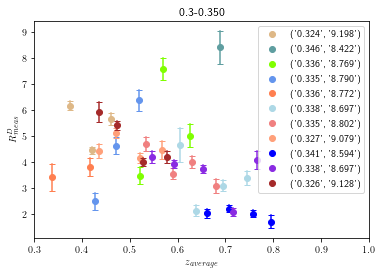

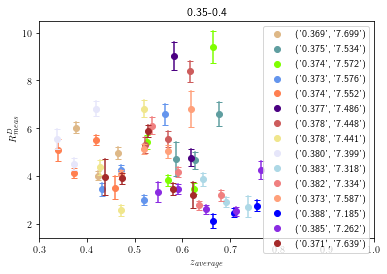

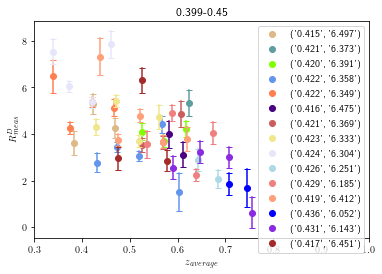

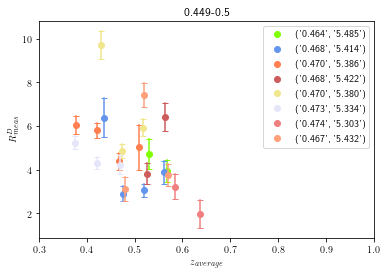

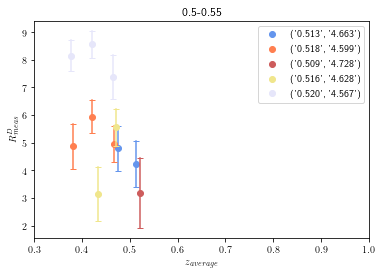

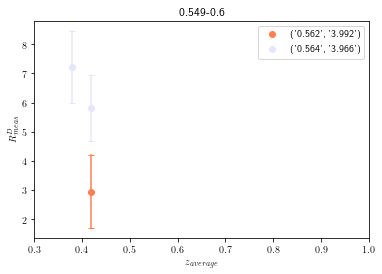

In [26]:
Q2 = 4
for key_xbj,xbj_value in RDxz["4.000000"].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RD=float(z_value["value"])
            RD_error = float(z_value["error"])
            RDs.append(float(z_value["value"]))
            RDs_error.append(float(z_value["error"]))
            z_corr = float(z_value["z_corr"])*z_hadron
            zs.append(z_corr)
            xbj_corr = float(z_value["xbj_corr"])*xbj
            xbj_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbj_corr)
            xbj_corr_errs.append(xbj_corr_err)
            ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = (xbj_corr_str[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])


      


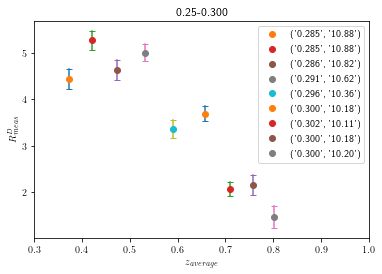

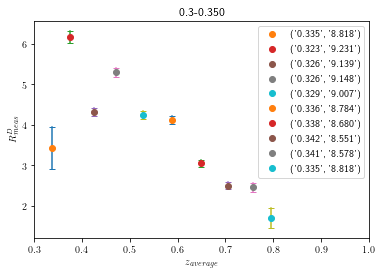

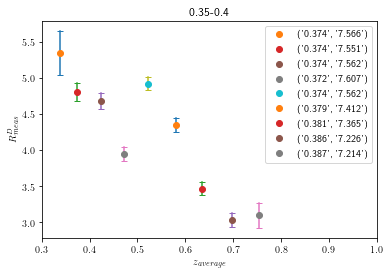

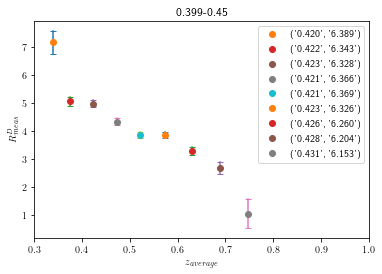

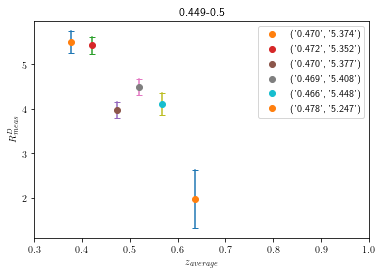

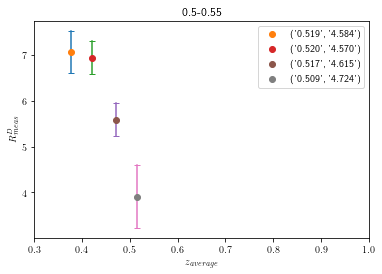

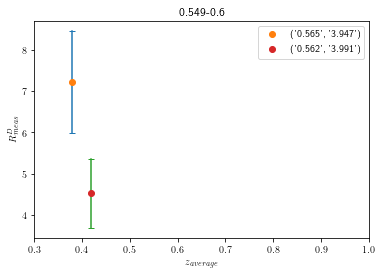

In [27]:
Q2 = 4.0
CSVs = []
CSVs_err = []
xbj_all_corr=[]
for key_xbj,xbj_value in RD_Q2xzRG["4.000000"].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        xbj_three_corr = []
        xbj_three_err_corr = []
        CSV_three = []
        CSV_three_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])*z_hadron
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])*z_hadron
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])*xbj
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_all_corr.append(xbj_corr)
        CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
        CSVxi_err = xbj_corr*CSVx_err(math.sqrt(Q2),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_three_corr.append(xbj_corr)
        xbj_threei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_three_err_corr.append(xbj_threei_err_corr)
        CSV_three.append(CSVxi)
        CSV_three_err.append(CSVxi_err)
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = (str(xbj_corr)[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
    xbj_three = Get_weighted_average(xbj_three_corr,xbj_three_err_corr)
    xbj_threes_corr.append(xbj_three)
    CSVxi_three = Get_weighted_average(CSV_three,CSV_three_err)
    CSVxi_three_err = Get_weighted_sigma(CSV_three,CSV_three_err)
    CSV_threes.append(CSVxi_three)
    CSV_threes_err.append(CSVxi_three_err)

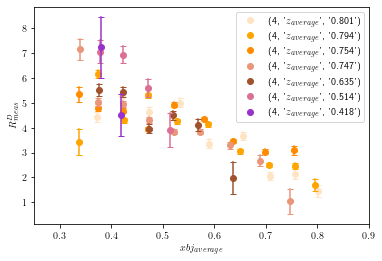

In [28]:
Q2 = 4
i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG["4.000000"].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])*z_hadron
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])*z_hadron
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])*xbj
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    plt.plot(z_corrs,RD_alls,"o",label = (Q2,r'$z_{average}$',str(z_corr)[0:5]),color = colors_all[i_color])
    plt.xlabel(r'$xbj_{average}$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    i_color +=1

Text(0.5, 0, '$x_{bj}$')

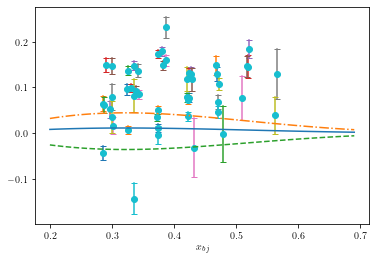

In [32]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")
plt.plot(xbj_all_corr,CSVs,"o")
        #CSVs_err
    


plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')

#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel(r'$x_{bj}$')
#plt.ylim(-0.3,0.6)

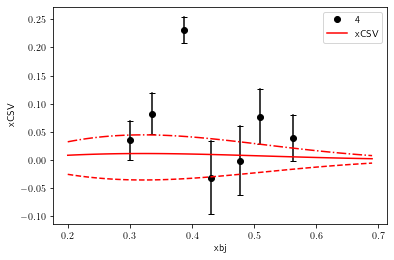

In [33]:
ax = fig.add_subplot()
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "k")
plt.plot(xbj_threes_corr,CSV_threes,"ko",label = Q2)
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
#plt.ylim(-0.3,0.6)
plt.legend()

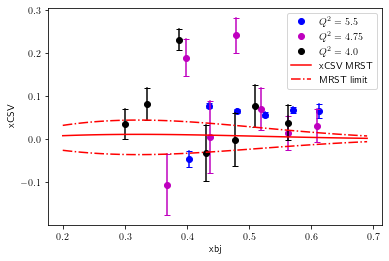

In [34]:
#ax = fig.add_subplot()
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "b")
plt.plot(xbj_ones_corr,CSV_ones,"bo",label = r'$Q^2 = 5.5$')
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo",label = r'$Q^2 = 4.75$')
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "k")
plt.plot(xbj_threes_corr,CSV_threes,"ko",label = r'$Q^2 = 4.0$')
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV MRST',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',label = 'MRST limit',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'-.',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
plt.legend()

In [ ]:
#ax = fig.add_subplot() This one is wrong. data is CSV, MRST is xCSV
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]/xbj_ones_corr[i]-CSV_ones_err[i]/xbj_ones_corr[i],CSV_ones[i]/xbj_ones_corr[i]+CSV_ones_err[i]/xbj_ones_corr[i]],marker = "_",color = "b")
    plt.plot(xbj_ones_corr[i],CSV_ones[i]/xbj_ones_corr[i],"bo")
plt.plot(xbj_ones_corr[1],CSV_ones[1]/xbj_ones_corr[1],"bo",label = r'$Q^2 = 5.5$')
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]/xbj_twos_corr[i]-CSV_twos_err[i]/xbj_twos_corr[i],CSV_twos[i]/xbj_twos_corr[i]+CSV_twos_err[i]/xbj_twos_corr[i]],marker = "_",color = "m")
    plt.plot(xbj_twos_corr[i],CSV_twos[i]/xbj_twos_corr[i],"mo")
plt.plot(xbj_twos_corr[1],CSV_twos[1]/xbj_twos_corr[1],"mo",label = r'$Q^2 = 4.75$')
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]/xbj_threes_corr[i]-CSV_threes_err[i]/xbj_threes_corr[i],CSV_threes[i]/xbj_threes_corr[i]+CSV_threes_err[i]/xbj_threes_corr[i]],marker = "_",color = "k")
    plt.plot(xbj_threes_corr[i],CSV_threes[i]/xbj_threes_corr[i],"ko")
plt.plot(xbj_threes_corr[1],CSV_threes[1]/xbj_threes_corr[1],"ko",label = r'$Q^2 = 4.0$')
plt.grid()       
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV MRST',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',label = 'MRST limit',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'-.',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
plt.legend()